### Multi-omic Dataset: Latent representation using Denoising Autoencoders
- Load Data
- Add Swap Noise to Data
- Normalize Data
- Define Autoencoder Model
- Train Autoencoder with normalized noisy dataset
- Use transformed dataset for classification
- Use transformed dataset for clustering
- Evaluation and Conclusions

In [2]:
import numpy as np
import random as rn
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

rn.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Load Data
X_renal_data = pd.read_csv('./x_exp_renal.csv', sep='\t') # Dataset has Donor ID as first column
y_renal_data = pd.read_csv('./y_renal.csv', sep=',') # Dataset has Donor ID on first column and Label on second column.

X_train_norm, X_train_swapped, X_test_norm, y_train, y_test, y_train_oh, y_test_oh = Models.prepare_datasets(X_renal_data.iloc[:,1:],y_renal_data["label"], test_size=0.2, swap_noise=0.15)

# We will use "X_train_swapped" as input training dataset and "X_train_norm" as output for the loss function of the Denoising Autoencoder

swapping: 65 rows.


Train on 433 samples
Epoch 1/80
433/433 [==============================] - 5s 13ms/sample - loss: 4.8536 - mse: 0.1490
Epoch 2/80
433/433 [==============================] - 3s 8ms/sample - loss: 1.3967 - mse: 0.1461
Epoch 3/80
433/433 [==============================] - 4s 9ms/sample - loss: 0.7701 - mse: 0.1414
Epoch 4/80
433/433 [==============================] - 4s 9ms/sample - loss: 0.5808 - mse: 0.1329
Epoch 5/80
433/433 [==============================] - 4s 9ms/sample - loss: 0.5361 - mse: 0.1188
Epoch 6/80
433/433 [==============================] - 4s 10ms/sample - loss: 0.5323 - mse: 0.0988
Epoch 7/80
433/433 [==============================] - 4s 10ms/sample - loss: 0.5896 - mse: 0.0762
Epoch 8/80
433/433 [==============================] - 4s 8ms/sample - loss: 0.6827 - mse: 0.0553
Epoch 9/80
433/433 [==============================] - 3s 8ms/sample - loss: 0.7593 - mse: 0.0406
Epoch 10/80
433/433 [==============================] - 3s 8ms/sample - loss: 0.7818 - mse: 0.0321
Epoch

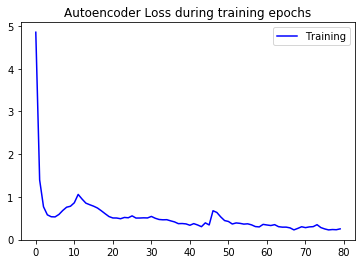

0.2526181122034306


In [4]:
###  Hyperparamter tuning
# MAP y_train from classes -1 and 1 to 0 and 1
y_train_map = ((y_train + 1)/2).astype(int)

dropouts = [0.08,0.09,0.01,0.011,0.012]
l1 = 0
l2 = 0
scores = []
for dropout in dropouts:
    ## Build and Train Autoencoder
    autoencoder, encoder, decoder, loss = Models.build_and_train_autoencoder(X_train_norm,
                                                                  X_train_norm,
                                                                  encoding_dim=50, 
                                                                  regularizer=tf.keras.regularizers.l1_l2(l1,l2),
                                                                  dropout=dropout,
                                                                  epochs=200)
    ## Encode datasets
    X_latent_ae = Models.encode_dataset(X_train_norm, encoder)
    X_latent_test_ae = Models.encode_dataset(X_test_norm, encoder)
    ### VISUALIZATION WITH PCA
    ## ORIGINAL DATASET
    X_latent_pca, X_latent_test_pca = Models.perform_PCA(X_train_norm, X_test_norm, y_train, y_test, n_components=10)
    ## AUTOENCODER LATENT SPACE
    X_latent_pca_ae, X_latent_test_pca_ae = Models.perform_PCA(X_latent_ae, X_latent_test_ae, y_train, y_test, n_components=10)
    
    ### CLASSIFICATION ###
    # We use the reduced dataset to train a classifier and compare it against the same classifier trained with the original dataset.
    lr_accuracy, svm_accuracy, rf_accuracy = Models.classify(X_latent_ae, X_latent_test_ae, y_train, y_test, model_type="AE")
    
    ### CLUSTERING ###
    silhouette, mutual_info = Models.cluster(X_latent_ae,y_train_map, model_type="AE")
    
    scores.append((dropout,l1,l2,loss,lr_accuracy,svm_accuracy,rf_accuracy,silhouette,mutual_info))

In [10]:
### CLASSIFICATION ###
# We use the reduced dataset to train a classifier and compare it against the same classifier trained with the original dataset.

# One hot encode labels
from sklearn.preprocessing import LabelEncoder
OH_encoder = LabelEncoder()
OH_y_train = pd.DataFrame(OH_encoder.fit_transform(y_train))
OH_y_test = pd.DataFrame(OH_encoder.transform(y_test))
y_train_oh = keras.utils.to_categorical(OH_y_train)
y_test_oh = keras.utils.to_categorical(OH_y_test)

## Definition of the best classifier obtained previously (CTG_dataset_classification)
def build_best_model(dropout: int, l1: int, l2: int, input_shape: int):
    model = keras.Sequential([
        layers.Dense(30, activation=tf.nn.relu ,kernel_regularizer=keras.regularizers.l1_l2(l1,l2), input_shape=(input_shape,)),
        layers.Dropout(dropout),
        layers.BatchNormalization(),
        layers.Dense(10,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1_l2(l1,l2)),
        layers.Dropout(dropout),
        layers.BatchNormalization(),
        layers.Dense(5,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1_l2(l1,l2)),
        layers.Dropout(dropout),
        layers.BatchNormalization(),
        layers.Dense(2,activation=tf.nn.softmax)
      ])

    optimizer = tf.keras.optimizers.Adam(0.01)

    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model


# Fit best model with dimensionality reduction data
model_ae = build_best_model(0.5,0.0001, 0.0001, X_train_encoded.shape[1])
history_ae = model_ae.fit(X_train_encoded, y_train_oh, epochs=400,
                    validation_split = 0.1, verbose=1, callbacks=[], shuffle=False)
hist_ae = pd.DataFrame(history_ae.history)

test_loss, test_acc = model_ae.evaluate(X_test_encoded, y_test_oh)

# Fit best model with concatenated data
#model = build_best_model(0.5,0.0001,0.0001, X_train_norm.shape[1])
#history = model.fit(X_train, y_train_oh, epochs=150,
#                    validation_split = 0.1, verbose=1, callbacks=[early_stop])
#hist = pd.DataFrame(history.history)

#test_loss, test_acc = model.evaluate(X_test, y_test_oh)

Train on 389 samples, validate on 44 samples
Epoch 1/400
389/389 [==============================] - 1s 2ms/sample - loss: 1.0320 - accuracy: 0.5707 - val_loss: 0.8316 - val_accuracy: 0.6591
Epoch 2/400
389/389 [==============================] - 0s 80us/sample - loss: 0.8507 - accuracy: 0.6607 - val_loss: 0.7972 - val_accuracy: 0.6591
Epoch 3/400
389/389 [==============================] - 0s 80us/sample - loss: 0.7807 - accuracy: 0.6967 - val_loss: 0.7886 - val_accuracy: 0.6591
Epoch 4/400
389/389 [==============================] - 0s 80us/sample - loss: 0.7179 - accuracy: 0.7378 - val_loss: 0.7845 - val_accuracy: 0.6591
Epoch 5/400
389/389 [==============================] - 0s 120us/sample - loss: 0.7067 - accuracy: 0.7378 - val_loss: 0.7794 - val_accuracy: 0.6591
Epoch 6/400
389/389 [==============================] - 0s 80us/sample - loss: 0.6978 - accuracy: 0.7404 - val_loss: 0.7693 - val_accuracy: 0.6591
Epoch 7/400
389/389 [==============================] - 0s 121us/sample - loss: 

### Conclusion
Here we trained an autoencoder using a dataset modified with noise, and used the original dataset to force the autoencoder to reconstruct it from a smaller latent space. This lead to a latent space of about 1000 times smaller than the original. When compared using classifiers and clustering methods, there is a drop in accuracy and a significant increase in silhouette score. The dimensionality reduction speeds the classifier training process and enables the training of more complex models in reduced amount of time.

Classifier Accuracy:

Silhouette Score: 0.8439
